In [10]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import os
import re

#need to pip install opencv-python
import cv2
from skimage.color import rgb2gray #convert RGB to gray color
#used to make a distribution of C (Inverse of regularization strength) in logistic regression
from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#You need scikit-optimize to run Bayesian Optimization faster.
# !pip install scikit-optimize
from skopt import BayesSearchCV

In [3]:
class_names = [class_name for class_name in os.listdir("../Images+augmentation/ImageFolder2") if not class_name.startswith(".")]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)
print(f"We have in total {nb_classes} different classes."+
      f"\nAnd they are:\n {', '.join(classes for classes in class_names)}.")

We have in total 11 different classes.
And they are:
 tshirt, sunglasses, watches, speaker, chair, shorts, phone, earbuds, hat, shoes, bottle.


In [4]:
#Load the data from each folder
def load_image_from_folder(root_dir, max_img_perclass = 4000):

    images = []
    labels = []
    IMAGE_SIZE = (150, 150)

    for folder in os.listdir(root_dir):
        #Because there are some configure file also sitting there  
        if folder.startswith("."):
            continue
        label = class_names_label[folder]
        total_img_perclass = 0
        for root, dirs, files in os.walk(os.path.join(root_dir, folder), topdown = True):
            # Get the path name of the image
            for file in files:
                img_path = os.path.join(root,file)
                #open and resize the image, read in as 3d array
                '''
                The reason we add try except is because some iamges just cannot be read in to cv2
                for example this one: ./updated images/watches/712+lS1mk-L._AC_UL320_.jpg
                I dont know why.

                Also, there are some corrupted images like this one: ./updated images/watches/814cT4PAxeL._AC_UL320_.jpg
                However, cv2 wont allow us to capture this images. We will still keep them in our image pool,
                because they dont really cause any issue.

                If you do want learn more read https://medium.com/joelthchao/programmatically-detect-corrupted-image-8c1b2006c3d3
                and
                https://scikit-image.org/
                '''
                try:
                    image = cv2.imread(img_path)
                    #cv2.cvtColor() method is used to convert an image from one color space to another.
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
                    #is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
                    #The aspect ratio is preserved when we specify the scaling factor.
                    image = cv2.resize(image, IMAGE_SIZE)
                except:
                    continue
                
                total_img_perclass += 1
                if total_img_perclass > max_img_perclass:
                    break
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
    # The original dtypes of image is uint8 (Unsigned integer type, from 0 to 18_446_744_073_709_551_615)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return ((images, labels))

In [5]:
import warnings
warnings.filterwarnings("ignore")
images, labels = load_image_from_folder('../Images+augmentation/ImageFolder2',max_img_perclass = 800)

#Shuffle arrays or sparse matrices in a consistent way.
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
#otherwise imaages are grouped all together based on their classes
images_r, labels_r = shuffle(images, labels, random_state=25)

Corrupt JPEG data: 1955 extraneous bytes before marker 0xc4
Corrupt JPEG data: 757 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 250 extraneous bytes before marker 0xc4
Corrupt JPEG data: 3186 extraneous bytes before marker 0xc4
Corrupt JPEG data: 4436 extraneous bytes before marker 0xc4
Corrupt JPEG data: 2472 extraneous bytes before marker 0xc4
Corrupt JPEG data: 897 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 1003 extraneous bytes before marker 0xc4
Corrupt JPEG data: 1312 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code


How many images in each class?


,,,,,,,,,,,
Class,bottle,chair,earbuds,hat,phone,shoes,shorts,speaker,sunglasses,tshirt,watches
Total Amount,800,800,800,800,800,800,800,800,800,800,800


Each image size is: (150, 150).


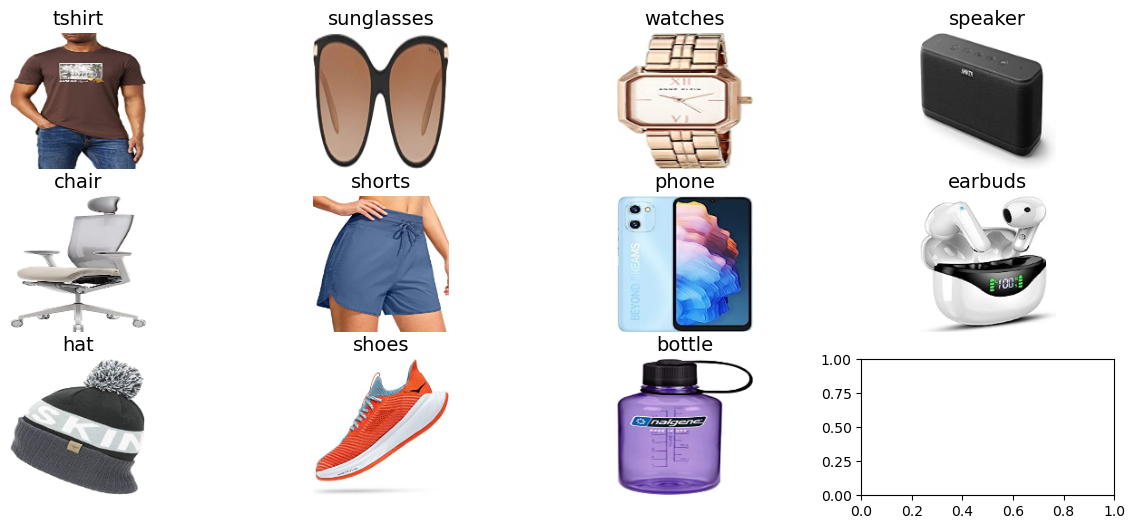

In [6]:
'''
How many images in each class?
'''

print("How many images in each class?")
class_name, count_name = np.array(np.unique(np.array(class_names)[labels_r], return_counts=True))
total_images = pd.DataFrame((class_name, count_name), 
             index = ["Class", "Total Amount"], columns = ['']*len(class_name))
display(total_images)

print(f"Each image size is: {IMAGE_SIZE}.")

#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    x = images_r[labels_r == i][0].astype('uint8')
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

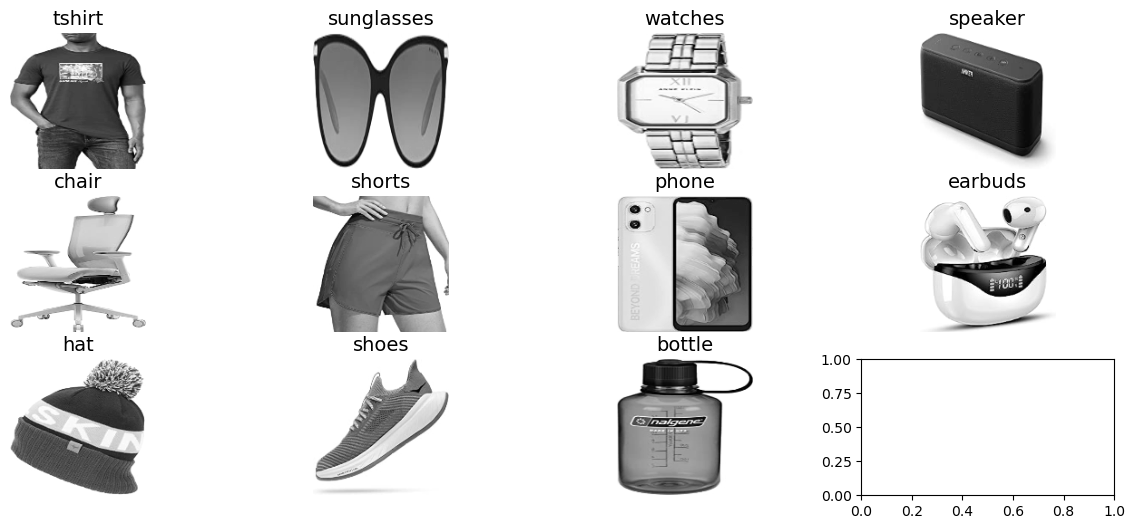

In [7]:
#1: remove colours
import warnings
warnings.filterwarnings("ignore")
images_r_g = np.zeros(images_r.shape[0:3])
for i in range(images_r.shape[0]):
    images_r_g[i] = rgb2gray(images_r[i])
    
#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    #x = images_r[labels_r == i][0].astype('uint8')
    x = images_r_g[labels_r == i][0]
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

In [ ]:
# #This is from Yong

# # Split the dataset into training (80%) and testing (20%)
# X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# # Normalization
# X_train_norm = X_train/255.0
# X_test_norm = X_test/255.0

# #reshape
# nsamples, nx, ny = X_train_norm.shape
# X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
# nsamples, nx, ny = X_test_norm.shape
# X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

# #look at the shaoe of training and testing
# X_train_norm.shape, X_test_norm.shape

In [9]:
# import numpy as np
# import pandas as pd

# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import seaborn as sns

# import tensorflow.keras as tk
# from keras.models import Sequential
# from keras.utils.np_utils import to_categorical
# from keras.regularizers import l1, l2
# from tensorflow.keras.utils import load_img, img_to_array
# from keras.preprocessing import sequence
# from keras.models import Model

# %matplotlib inline

In [37]:
# from keras.layers import Dropout
# from keras.layers import Dense

In [12]:

# print(X_train.shape)
# print(np.max(X_train))

# # the y_train the group label for the training data
# print(y_train.shape)
# print(np.unique(y_train))

In [11]:
#This is from Yong:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [41]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

#look at the shaoe of training and testing
X_train_norm.shape, X_test_norm.shape

# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape input data
X_train = X_train.reshape(-1, 150, 150, 1)
X_test = X_test.reshape(-1, 150, 150, 1)

# define a function that creates the Keras model
def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(11, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# create the Keras classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=32, verbose=2)

# define the hyperparameter search space
param_grid_cnn = {
    'learning_rate': [0.001, 0.01, 0.1]
}

# set up early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

# perform random search cross-validation
cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid_cnn, n_iter=15, cv=3, verbose=2, n_jobs=6)
cv.fit(X_train, y_train, callbacks=[early_stopping], validation_split=0.2)


# print the best hyperparameters and test accuracy
print("Best hyperparameters: ", cv.best_params_)
print("Test accuracy: %.3f" % cv.score(X_test, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
118/118 - 218s - loss: 52.6267 - accuracy: 0.0945 - val_loss: 2.4062 - val_accuracy: 0.0735 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 218s - loss: 3.8431 - accuracy: 0.4115 - val_loss: 1.4164 - val_accuracy: 0.5708 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 218s - loss: 29.0295 - accuracy: 0.0847 - val_loss: 2.4086 - val_accuracy: 0.0927 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 218s - loss: 3.3945 - accuracy: 0.3895 - val_loss: 1.6142 - val_accuracy: 0.4846 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 219s - loss: 3.5189 - accuracy: 0.4081 - val_loss: 1.3301 - val_accuracy: 0.5921 - 219s/epoch - 2s/step
Epoch 2/15
118/118 - 219s - loss: 50.8510 - accuracy: 0.0898 - val_loss: 2.4046 - val_accuracy: 0.0863 - 219s/epoch - 2s/step
Epoch 2/15
118/118 - 213s - loss: 2.4061 - accuracy: 0.0868 - val_loss: 2.4065 - val_accuracy: 0.0937 - 213s/epoch - 2s/step
Epoch 3/

2023-04-02 17:02:24.530234: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 17:02:24.608521: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8911340290 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-02 17:02:24.608536: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/20
176/176 [==============================] - 96s 548ms/step - loss: 1.7026 - accuracy: 0.4618 - val_loss: 1.2891 - val_accuracy: 0.5987
Epoch 2/20
176/176 [==============================] - 98s 555ms/step - loss: 1.1606 - accuracy: 0.6431 - val_loss: 1.0874 - val_accuracy: 0.6683
Epoch 3/20
176/176 [==============================] - 96s 545ms/step - loss: 1.0012 - accuracy: 0.6967 - val_loss: 1.0050 - val_accuracy: 0.6868
Epoch 4/20
176/176 [==============================] - 98s 556ms/step - loss: 0.8900 - accuracy: 0.7225 - val_loss: 0.9828 - val_accuracy: 0.7003
Epoch 5/20
176/176 [==============================] - 103s 584ms/step - loss: 0.7938 - accuracy: 0.7541 - val_loss: 0.9243 - val_accuracy: 0.7095
Epoch 6/20
176/176 [==============================] - 100s 567ms/step - loss: 0.7027 - accuracy: 0.7825 - val_loss: 0.9771 - val_accuracy: 0.7031
Epoch 7/20
176/176 [==============================] - 103s 583ms/step - loss: 0.6358 - accuracy: 0.8065 - val_loss: 0.8887 - val

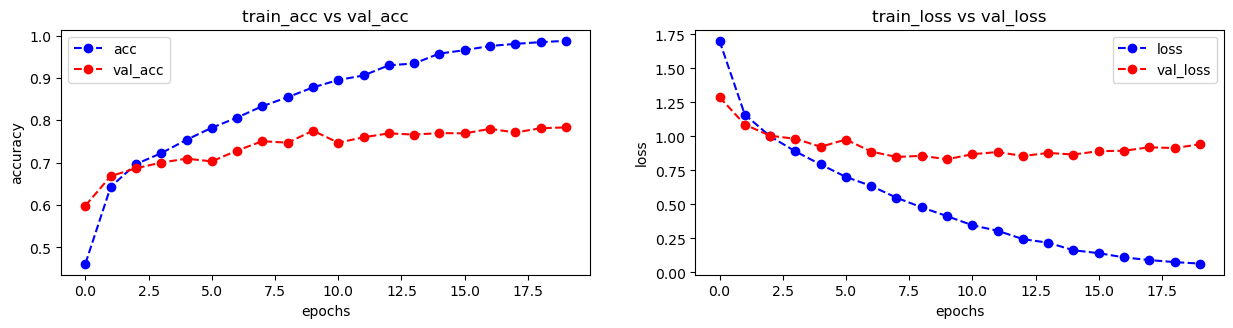

In [14]:
#This part is modified from Stu by Yong for CNN

# Split the dataset into training (80%) and testing (20%)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm_cnn = X_train_cnn/255.0
X_test_norm_cnn = X_test_cnn/255.0
#tf.keras.layers.Conv2D is expecting 3 dimensions for each image
X_train_norm_cnn= X_train_norm_cnn.reshape(-1,150,150,1)
X_test_norm_cnn= X_test_norm_cnn.reshape(-1,150,150,1)

'''
Best hyperparameters:  {'learning_rate': 0.0001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'}
'''

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'tanh', input_shape = (150, 150, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(11, activation='softmax')
])
'''
What is the difference between sparse_categorical_crossentropy and categorical_crossentropy?
https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c
Loss function: we use sparse categorical crossentropy for classification, each images belongs to one class only
'''
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(X_train_norm_cnn, y_train_cnn, callbacks=[early_stopping], batch_size=32, epochs=20, validation_split = 0.2)
#Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(X_test_norm_cnn, y_test_cnn)
print('Test accuracy: %.3f' % acc)


#we can plot the metric history 
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,7))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)

#### Confusion Matrix and Error Analysis for CNN

In [15]:
#Use the model to predict the test images
#predicitons.shape[0] is the same as X_test_norm_cnn.shape[0]
predicitons = model.predict(X_test_norm_cnn)
# We take the highest probability
pred_labels = np.argmax(predicitons, axis = 1)

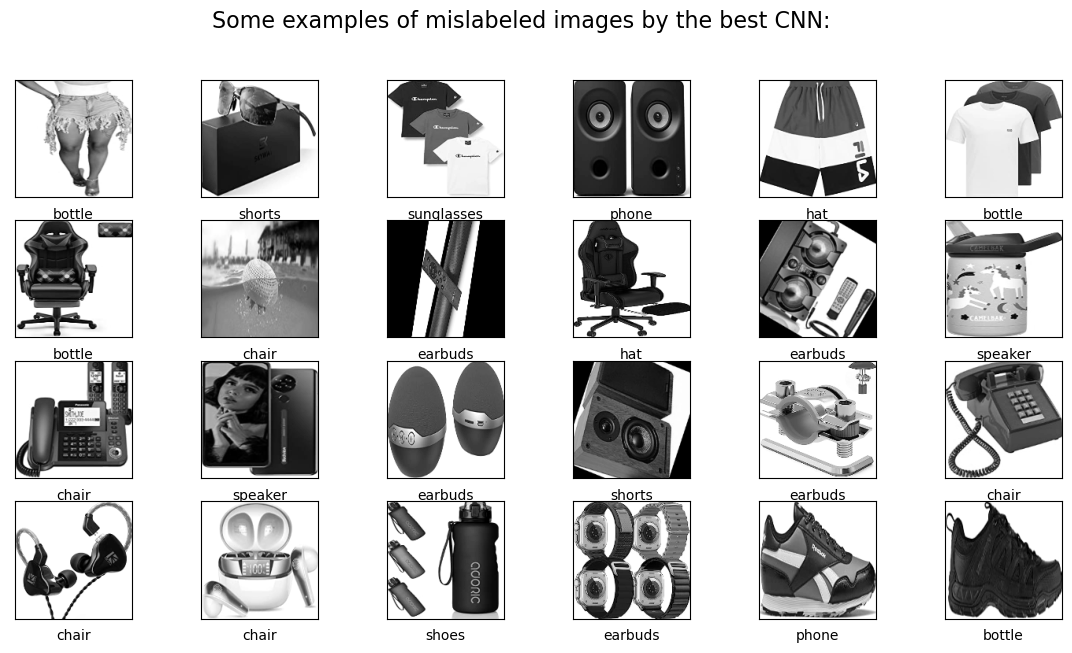

In [20]:
#Print out those images that has wrong prediciton label

def display_examples(class_names, images, labels, suptitle):
    """
        Display 24 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(14,7))
    fig.suptitle(suptitle, fontsize=16)
    for i in range(24):
        plt.subplot(4,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.xlabel(class_names[labels[i]])
    plt.show()

def print_mislabeled_images(class_names, test_images, test_labels, pred_labels, suptitle):
    """
        Print 24 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    
    display_examples(class_names,  mislabeled_images, mislabeled_labels, suptitle)

title = "Some examples of mislabeled images by the best CNN:"
print_mislabeled_images(class_names, X_test_cnn, y_test_cnn, pred_labels, title)

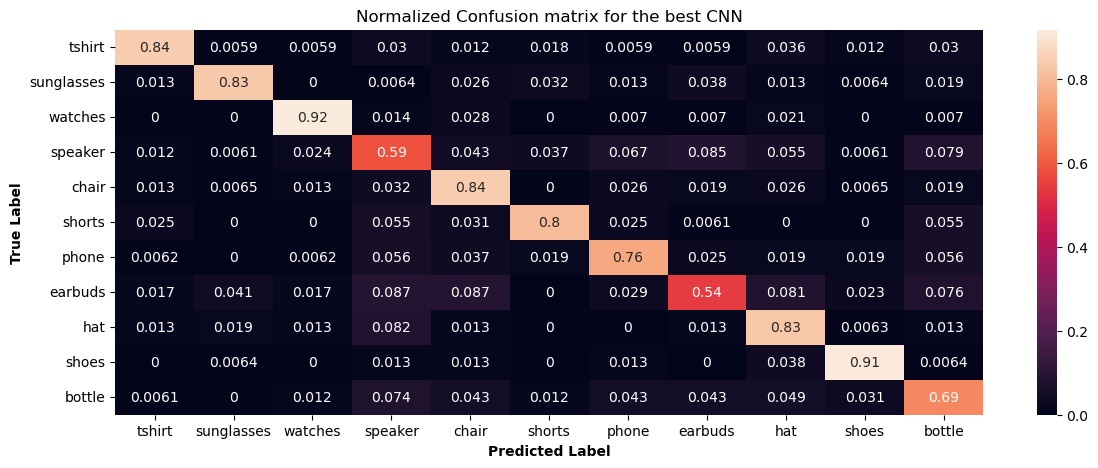

In [21]:
#confusion matrix
'''
Y is true labe, X is predicted label
'''
import seaborn as sn
fig, ax = plt.subplots(figsize=(14,5))
CM = confusion_matrix(y_test_cnn, pred_labels)
row_sums = CM.sum(axis=1)
new_matrix = CM / row_sums[:, np.newaxis]
sn.heatmap(new_matrix, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Normalized Confusion matrix for the best CNN')
ax.set_xlabel("Predicted Label",fontweight ='bold')
ax.set_ylabel("True Label",fontweight ='bold')

plt.show()


55/55 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1841
Test accuracy: 0.184


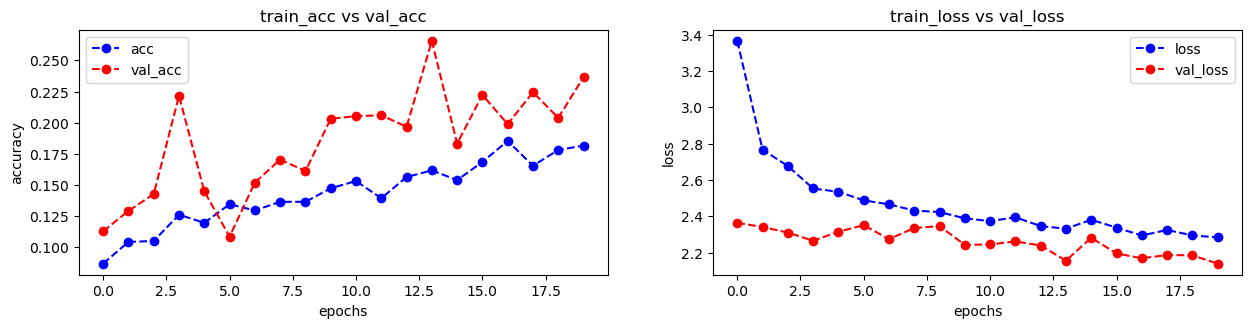

In [23]:
#This part is modified from Stu by Yong for MLP

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

'''
Best hyperparameters:  {'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>, 
'n_components': 10, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'}
'''
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation = 'tanh', input_shape = (X_train_norm.shape[1],)), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(11, activation='softmax')
])
'''
What is the difference between sparse_categorical_crossentropy and categorical_crossentropy?
https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c
Loss function: we use sparse categorical crossentropy for classification, each images belongs to one class only
'''
model_mlp.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history_mlp = model_mlp.fit(X_train_norm, y_train, callbacks=[early_stopping], batch_size=32, epochs=20, validation_split = 0.2)
#Returns the loss value & metrics values for the model in test mode.
_, acc_mlp = model_mlp.evaluate(X_test_norm, y_test)
print('Test accuracy: %.3f' % acc_mlp)


#we can plot the metric history 
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,7))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history_mlp)

In [42]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

# Reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape input data
X_train = X_train.reshape(-1, 150, 150, 1)
X_test = X_test.reshape(-1, 150, 150, 1)

# Define a function that creates the Keras model
def create_model(learning_rate=0.01, activation='relu', batch_size=32, epochs=15):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation, input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation=activation))
    model.add(Dropout(rate=0.4))
    model.add(Dense(12, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the Keras classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=2)

# Define the hyperparameter search space
param_grid_cnn = {
    'learning_rate': [0.0001, 0.001],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'batch_size': [16, 32, 64],
    'epochs': [20]
}

# Set up early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

# Perform random search cross-validation
cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid_cnn, n_iter=15, cv=3, verbose=2, n_jobs=6)
cv.fit(X_train, y_train, callbacks=[early_stopping], validation_split=0.2)


# print the best hyperparameters and test accuracy
print("Best hyperparameters: ", cv.best_params_)
print("Test accuracy: %.3f" % cv.score(X_test, y_test))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
59/59 - 218s - loss: 3.9646 - accuracy: 0.0945 - val_loss: 2.4848 - val_accuracy: 0.0735 - 218s/epoch - 4s/step
Epoch 2/20
118/118 - 220s - loss: 3.4865 - accuracy: 0.0945 - val_loss: 2.3867 - val_accuracy: 0.1565 - 220s/epoch - 2s/step
Epoch 2/20
59/59 - 223s - loss: 3.7731 - accuracy: 0.0868 - val_loss: 2.4047 - val_accuracy: 0.1086 - 223s/epoch - 4s/step
Epoch 2/20
59/59 - 224s - loss: 3.4723 - accuracy: 0.1145 - val_loss: 2.2862 - val_accuracy: 0.1544 - 224s/epoch - 4s/step
Epoch 2/20
118/118 - 225s - loss: 3.1914 - accuracy: 0.1188 - val_loss: 2.2625 - val_accuracy: 0.2034 - 225s/epoch - 2s/step
Epoch 2/20
118/118 - 226s - loss: 3.5668 - accuracy: 0.0890 - val_loss: 2.4265 - val_accuracy: 0.1086 - 226s/epoch - 2s/step
Epoch 2/20
59/59 - 220s - loss: 2.9130 - accuracy: 0.0932 - val_loss: 2.4714 - val_accuracy: 0.0735 - 220s/epoch - 4s/step
Epoch 3/20
118/11

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

# PCA
n_components = 10  # Change this parameter to adjust the number of principal components
# Reshape the input data
nsamples, nx, ny = X_train_norm.shape
X_train_norm_2d = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm_2d = X_test_norm.reshape((nsamples, nx*ny))

# Apply PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_norm_2d)
X_test_pca = pca.transform(X_test_norm_2d)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define a function that creates the Keras model
def create_model(n_components, learning_rate=0.01, activation='relu', batch_size=32, epochs=15):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(n_components,)))
    model.add(Dropout(rate=0.4))
    model.add(Dense(12, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the hyperparameter search space
param_grid_cnn = {
    'learning_rate': [0.0005, 0.001, 0.005],
    'activation': ['tanh'],
    'batch_size': [32],
    'epochs': [20],
    'n_components': [2,3,4,5,6,7,8,9,10]
}

# create the Keras classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=2)

# set up early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

# perform random search cross-validation
cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid_cnn, n_iter=15, cv=3, verbose=2, n_jobs=6)
cv.fit(X_train_pca, y_train, callbacks=[early_stopping], validation_split=0.2)

# print the best hyperparameters and test accuracy
print("Best hyperparameters: ", cv.best_params_)
print("Test accuracy: %.3f" % cv.score(X_test_pca, y_test))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.001, n_components=9; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.001, n_components=9; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.001, n_components=9; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.005, n_components=5; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.005, n_components=5; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.005, n_components=5; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.005, n_components=2; total time=   0.1s
Epoch 1/20
[CV] END activation=tanh, batch_size=32, epochs=20, learning_rate=0.005, n_components=2; total 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

# PCA
n_components = 10  # Change this parameter to adjust the number of principal components
# Reshape the input data
nsamples, nx, ny = X_train_norm.shape
X_train_norm_2d = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm_2d = X_test_norm.reshape((nsamples, nx*ny))

# Apply PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_norm_2d)
X_test_pca = pca.transform(X_test_norm_2d)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define a function that creates the Keras model
def create_model(n_components, optimizer='adam', learning_rate=0.01, activation='relu', batch_size=32, epochs=15):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(n_components,)))
    model.add(Dropout(rate=0.4))
    model.add(Dense(12, activation='softmax'))
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the hyperparameter search space
param_grid_cnn = {
    'optimizer': [keras.optimizers.Adam, keras.optimizers.RMSprop],
    'learning_rate': [0.0005, 0.001, 0.005],
    'activation': ['tanh'],
    'batch_size': [32],
    'epochs': [20],
    'n_components': [10]
}

# create the Keras classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=2)

# set up early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

# perform random search cross-validation
cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid_cnn, n_iter=20, cv=3, verbose=2, n_jobs=6)
cv.fit(X_train_pca, y_train, callbacks=[early_stopping], validation_split=0.2)

# print the best hyperparameters and test accuracy
print("Best hyperparameters: ", cv.best_params_)
print("Test accuracy: %.3f" % cv.score(X_test_pca, y_test))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
118/118 - 1s - loss: 2.1335 - accuracy: 0.3652 - val_loss: 1.5878 - val_accuracy: 0.5240 - 746ms/epoch - 6ms/step
Epoch 2/20
118/118 - 1s - loss: 2.1966 - accuracy: 0.3460 - val_loss: 1.5995 - val_accuracy: 0.5208 - 742ms/epoch - 6ms/step
Epoch 2/20
118/118 - 1s - loss: 2.1279 - accuracy: 0.3614 - val_loss: 1.5262 - val_accuracy: 0.5325 - 737ms/epoch - 6ms/step
Epoch 2/20
118/118 - 1s - loss: 2.0954 - accuracy: 0.3644 - val_loss: 1.5723 - val_accuracy: 0.5272 - 796ms/epoch - 7ms/step
Epoch 2/20
118/118 - 1s - loss: 2.1138 - accuracy: 0.3647 - val_loss: 1.5933 - val_accuracy: 0.4963 - 799ms/epoch - 7ms/step
Epoch 2/20
118/118 - 1s - loss: 2.0001 - accuracy: 0.4043 - val_loss: 1.5014 - val_accuracy: 0.5559 - 852ms/epoch - 7ms/step
Epoch 2/20
118/118 - 0s - loss: 1.7549 - accuracy: 0.4712 - val_loss: 1.5011 - val_accuracy: 0.5282 - 261ms/epoch - 2ms/step
Epoch 3/20